<a href="https://colab.research.google.com/github/tanvu10/Hidden_Markov_Model/blob/master/HMM_stock_predicting_method_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install hmmlearn
from hmmlearn import hmm 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
stock = pd.read_csv('VNINDEX1.csv')
stock

,Date,Open,High,Low,Close,Volume
0,2000-07-28,100.0000,100.00,100.00,100.00,4200
1,2000-07-31,101.5500,101.55,101.55,101.55,10300
2,2000-08-02,103.3800,103.38,103.38,103.38,300
3,2000-08-04,105.2000,105.20,105.20,105.20,3800
4,2000-08-07,106.9200,106.92,106.92,106.92,13200
...,...,...,...,...,...,...
5137,2021-10-18,1395.5699,1402.63,1390.88,1395.53,740018700
5138,2021-10-19,1395.5300,1399.66,1388.95,1395.33,582318100
5139,2021-10-20,1398.4500,1401.76,1376.15,1393.80,771825800
5140,2021-10-21,1397.5900,1398.45,1384.77,1384.77,659155300


In [3]:
def data_processing(dataframe):        
    # dataframe['Date'] = [i.split(' ')[0][:] for i in dataframe['Date']]
    dataframe['Date'] = dataframe['Date'].apply(pd.Timestamp) #very important: convert string to date
    dataframe = dataframe[dataframe['Date'] >= pd.to_datetime('2015-01-01' , format='%Y-%m-%d')]
    dataframe.set_index(['Date'], inplace = True)
    return dataframe


def return_cal(dataframe):
    dataframe['return'] = (dataframe['Close'] - dataframe['Close'].shift(1))/dataframe['Close'].shift(1)
    dataframe.dropna(inplace  = True)

In [4]:
stock = data_processing(stock)
return_cal(stock)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [5]:
train = stock[:'2021-09-01']
test = stock['2021-09-02':]
# print(train)
print(test)
test.iloc[:-1, :]
test.iloc[-1,5]
# test.iloc[1,3]
# len(test)
# test.iloc[:14,:]
# sim = pd.concat([train, test.iloc[:1,:]], axis =0 )
# sim

                 Open       High        Low      Close     Volume    return
Date                                                                       
2021-09-06  1340.7100  1348.3600  1339.8000  1346.3900  871508000  0.008796
2021-09-07  1349.1300  1353.6600  1340.3199  1341.9000  829928300 -0.003335
2021-09-08  1343.9200  1344.4900  1328.3500  1333.6100  580802100 -0.006178
2021-09-09  1333.6100  1345.5900  1332.6700  1343.9800  563607000  0.007776
2021-09-10  1348.7400  1350.4301  1345.0699  1345.3101  530762800  0.000990
2021-09-13  1348.0699  1350.6899  1340.5000  1341.4301  719863400 -0.002884
2021-09-14  1343.3800  1349.1300  1336.8400  1339.7000  670954500 -0.001290
2021-09-15  1338.1100  1347.7000  1334.9700  1345.8300  622274200  0.004576
2021-09-16  1351.8500  1353.1200  1341.2300  1345.8700  547188700  0.000030
2021-09-17  1347.6600  1356.4500  1347.1300  1352.6400  773922200  0.005030
2021-09-20  1361.1200  1365.9200  1349.1801  1350.4800  820277200 -0.001597
2021-09-21  

0.0032279728763621594

In [6]:
def best_state_count(dataframe):
    # aic_vec = []
    bic_vec = []
    M_obs_point = dataframe.shape[1]
    #choose state randomly from 2-6:
    for state in range(2,7):
        param_num = state**2 + state - 1
        #tol: convergence threshold
        #use full cov matrix
        model = hmm.GaussianHMM(n_components=state, covariance_type = 'full', tol = 0.0001, n_iter= 10000)
        model.fit(dataframe.iloc[:, :5])
        
        # aic = -2*model.score(dataframe.iloc[:,:5]) + 2*param_num
        # aic_vec.append(aic)
        bic_vec.append( -2*model.score(dataframe.iloc[:,:5]) + param_num*np.log(M_obs_point) )

    optimal_state = np.argmin(bic_vec)
    return optimal_state

In [7]:
optimal_state = best_state_count(train)

In [8]:
print(optimal_state)

4


In [9]:
def prediction(train, test):
    test_length = test.shape[0]
    
    p_prediction = []
    r_prediction = []
    for i in range(test_length+1):
    
        if i == 0:
            new_train = train
            model = hmm.GaussianHMM(n_components=optimal_state, covariance_type= 'full', tol = 0.0001, n_iter = 10000)
        if i != 0:
            new_train = pd.concat([train, test.iloc[:i,:]], axis = 0)
            model = hmm.GaussianHMM(n_components=optimal_state,init_params='' , 
                                    covariance_type= 'full', tol = 0.0001, n_iter = 10000)
            #reuse from previous step:
            model.transmat_ = transmat_prior 
            model.startprob_ = startprob_prior
            model.means_ = means_prior
            model.covars_ = covars_prior

        model.fit(new_train)
        transmat_prior = model.transmat_
        startprob_prior = model.startprob_
        means_prior = model.means_
        covars_prior = model.covars_

        #backward_check
        current_score = model.score(new_train)
        gap = 1000
        for j in reversed(range(1, new_train.shape[0])):
            new_set = new_train.iloc[:j, :]  #from index 0 to j-1, inclusive
            current_gap = np.abs(current_score - model.score(new_set))
            current_sign = np.sign(current_score - model.score(new_set))
            if current_gap < gap:
                sign = current_sign
                gap = current_gap
                best_index = j
             
        

        price_prediction = new_train.iloc[-1,3]   +    (new_train.iloc[best_index,3] - new_train.iloc[best_index-1,3]) * np.sign(sign)
        p_prediction.append(price_prediction)
        return_prediction = new_train.iloc[-1,5]   +    (new_train.iloc[best_index,5] - new_train.iloc[best_index-1,5]) * np.sign(sign)
        r_prediction.append(return_prediction)
    return p_prediction,r_prediction 


In [10]:
price_vector, return_vector  = prediction(train, test)

In [11]:
# prediction_vector

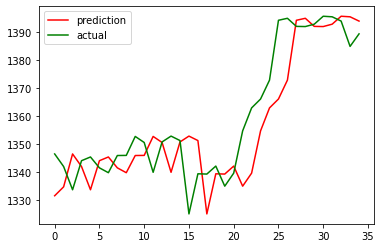

In [13]:
# len(prediction_vector[:15])
plt.plot(price_vector[:-1], color  = 'red', label = 'prediction')
plt.plot(np.array(test.iloc[:,3]), color = 'green', label = 'actual')
plt.legend(loc="upper left")
plt.show()

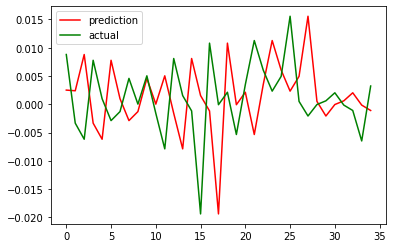

In [14]:
plt.plot(return_vector[:-1], color  = 'red', label = 'prediction')
plt.plot(np.array(test.iloc[:,5]), color = 'green', label = 'actual')
plt.legend(loc="upper left")
plt.show()